# Language Modeling

## Notebook Overview

This notebook extends the lab exercise 'Text Analysis and Preprocessing Pipeline' by building unigram and bigram language models on top of the cleaned tweet corpus. Language models estimate how plausible a sequence of tokens is. 

### What you will build
- reuse the cleaned tweet corpus from Lab 2
- implement unigram and bigram language models with Laplace smoothing
- evaluate both models on held-out data with perplexity
- interpret the learned distributions and compare them to NLTK baselines

### Section roadmap
1. `Section 1` loads the preprocessed corpus and defines reusable helpers.
2. `Section 2` implements custom unigram and bigram models in log-space.
3. `Section 3` evaluates the models with perplexity on a test split.
4. `Section 4` inspects frequent and rare n-grams to understand model behaviour.
5. `Section 5` (optional) validates our implementation against NLTK's reference models.

---

### Install Required Libraries

Installation of pandas (data loading/manipulation), NumPy (vectorised helpers), matplotlib (diagnostics), and scikit-learn's `train_test_split` (deterministic splits). Installing them together at the top prevents missing-package interruptions once we reach the modelling sections.


In [33]:
%pip installt pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib

ERROR: unknown command "installt" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Corpus Preparation & Utilities

### 1.1 Goal 
Reuse the preprocessed tweets from the previous lab and provide helper functions so that every subsequent experiment works with consistent tokenization.

### 1.2 Steps in this section
1. Load the preprocessed dataset from `../Data/df_preprocessed.parquet`.
2. Convert each tweet into a token list that our models can consume.
3. Define helper utilities (`train_test_split_corpus`, `ensure_tokens`) that standardise splitting and token handling across the notebook.

### 1.3 Why this matters
Clean train/test splits and consistent token handling ensure that probability estimates are comparable between our custom models and the NLTK baselines we train later.

In [34]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Sequence, Tuple, Union, Iterable
from sklearn.model_selection import train_test_split


DATA_PATH = "../Data/tweets_preprocessed_train.parquet"
RANDOM_STATE = 42


Corpus = List[List[str]]  # type alias for readability


def load_corpus(path: str) -> Corpus:
    """
    Load preprocessed text from a parquet and return tokenized sentences.
    Assumes a 'text' column containing cleaned strings.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")

    df = pd.read_parquet(p)
    if "text" not in df.columns:
        raise KeyError("Expected a 'text' column in the parquet file.")

    # Drop NaN/empty rows and standardize whitespace
    texts = (
        df["text"]
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
    )

    # Tokenize by whitespace
    corpus: Corpus = [t.split() for t in texts.tolist()]
    if len(corpus) == 0:
        raise ValueError("Corpus is empty after cleaning. Check preprocessing output.")

    return corpus


def train_test_split_corpus(
    corpus: Sequence[Sequence[str]],
    test_size: float = 0.2,
    random_state: int = RANDOM_STATE,
) -> Tuple[Corpus, Corpus]:
    """Split corpus into train/test partitions using sklearn's helper."""
    train, test = train_test_split(
        corpus, test_size=test_size, random_state=random_state
    )
    return [list(sent) for sent in train], [list(sent) for sent in test]


def ensure_tokens(sentence: Union[Sequence[str], str]) -> List[str]:
    """Convert a whitespace separated string or an iterable of tokens into a token list."""
    if isinstance(sentence, str):
        sentence = sentence.split()
    return list(sentence)


corpus = load_corpus(DATA_PATH)
print(f"Loaded {len(corpus)} preprocessed sentences.")
if corpus:
    print("Example tokens:", corpus[0][:10])

Loaded 6090 preprocessed sentences.
Example tokens: ['lumber', 'beat', 'rapid', 'game', 'western', 'division', 'final', 'evan', 'edwards', 'hit']


## 2. Custom N-gram Language Models

In the second part we implement unigram and bigram models. Unigrams capture individual word preferences while bigrams add short-range context. Together they form the foundation for more complex n-gram models and help us reason about smoothing and sparsity.

### 2.1 Implementation notes
We implement reusable Python classes that count tokens, apply Laplace smoothing, and return log probabilities. Working in log-space prevents numerical underflow and makes sentence scoring additive.

### 2.2 Quick diagnostic prints
After defining both classes we instantiate them on the training split and inspect example log-probabilities/perplexities to verify that counts and smoothing behave as expected.


### Unigram Model

- Count token frequencies over the training split once to obtain `P(w)` estimates.
- Store the vocabulary size and total tokens to enable efficient Laplace smoothing.
- Explain that add-one smoothing prevents zero probabilities so every token in the test set receives finite mass.
Documenting these steps clarifies how we handle sparsity before moving to contextual models.

In [35]:
class UnigramLM:
    """Laplace-smoothed Unigram Language Model (log-space)."""

    def __init__(self, corpus: Sequence[Sequence[str]]):
        self.unigram_counts = Counter()
        self.vocab = set()
        self.total_tokens = 0

        for sentence in corpus:
            tokens = ensure_tokens(sentence)
            self.unigram_counts.update(tokens)
            self.vocab.update(tokens)
            self.total_tokens += len(tokens)

        if self.total_tokens == 0:
            raise ValueError("Cannot train a UnigramLM on an empty corpus.")

        self.vocab_size = len(self.vocab)
        self._denom = self.total_tokens + self.vocab_size
        self._log_denom = math.log(self._denom)

        # Log-P(w) vorberechnen
        self._log_probs = {
            w: math.log(self.unigram_counts[w] + 1) - self._log_denom
            for w in self.vocab
        }
        self._log_unseen = math.log(1.0) - self._log_denom

    def log_prob(self, word: str) -> float:
        """log P(word) mit Laplace-Glättung."""
        return self._log_probs.get(word, self._log_unseen)

    def sentence_log_prob(self, sentence: Union[str, Sequence[str]]) -> float:
        """log P(Satz) = Summe log P(w)."""
        tokens = ensure_tokens(sentence)
        if not tokens:
            return float("-inf")
        return sum(self.log_prob(w) for w in tokens)

    def perplexity(self, sentences: Iterable[Union[str, Sequence[str]]]) -> float:
        """PP = exp(-Σ log P / N)."""
        total_log_prob, token_count = 0.0, 0
        for s in sentences:
            toks = ensure_tokens(s)
            if not toks:
                continue
            total_log_prob += self.sentence_log_prob(toks)
            token_count += len(toks)
        if token_count == 0:
            return float("inf")
        return math.exp(-total_log_prob / token_count)

    def most_common(self, n=10):
        return self.unigram_counts.most_common(n)

### Bigram Model

- Collect conditional counts `P(w_i | w_{i-1})` using `defaultdict(Counter)` for readability.
- Apply Laplace smoothing per context and compute in log-space to avoid underflow when multiplying probabilities.
- Include a brief rationale for batching observations (e.g., iterate sentence by sentence to maintain start tokens).
This explanation shows how the model captures short-range dependencies beyond the unigram baseline.


In [36]:
class BigramLM:
    """
    Simple Laplace-smoothed bigram language model (log-space)."""

    def __init__(self, corpus: Sequence[Sequence[str]]):
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocab = set()

        # Count unigrams & bigrams 
        for sentence in corpus:
            toks = ensure_tokens(sentence)
            if not toks:
                continue
            self.unigram_counts.update(toks)
            self.vocab.update(toks)
            for w_prev, w in zip(toks, toks[1:]):
                self.bigram_counts[w_prev][w] += 1

        self.vocab_size = len(self.vocab)
        self.total_tokens = sum(self.unigram_counts.values())
        if self.total_tokens == 0:
            raise ValueError("Cannot train a BigramLM on an empty corpus.")

        # Unigram (Laplace): (count(w) + 1) / (N + |V|)
        self._uni_denom = self.total_tokens + self.vocab_size
        self._log_uni_denom = math.log(self._uni_denom)
        self._log_uni = {
            w: math.log(self.unigram_counts[w] + 1) - self._log_uni_denom
            for w in self.vocab
        }
        self._log_uni_unseen = math.log(1.0) - self._log_uni_denom  # OOV

        # Bigram (Laplace): (count(prev, w) + 1) / (count(prev) + |V|)
        self._log_bi_denom = {
            prev: math.log(self.unigram_counts[prev] + self.vocab_size)
            for prev in self.unigram_counts
        }
        self._log_bi_denom_default = math.log(self.vocab_size) if self.vocab_size > 0 else 0.0

    def log_prob_unigram(self, word: str) -> float:
        """log P(word) with Laplace smoothing."""
        return self._log_uni.get(word, self._log_uni_unseen)

    def log_prob(self, prev_word: str, word: str) -> float:
        """log P(word | prev_word) with Laplace smoothing."""
        big_ct = self.bigram_counts[prev_word].get(word, 0)
        if prev_word in self._log_bi_denom:
            return math.log(big_ct + 1.0) - self._log_bi_denom[prev_word]
        # unseen context → pure Laplace with uniform 1/|V|
        return math.log(1.0) - self._log_bi_denom_default

    def sentence_log_prob(self, sentence: Union[str, Sequence[str]]) -> float:
        """log P(sentence) with unigram for the first token, then bigrams."""
        toks = ensure_tokens(sentence)
        if not toks:
            return float("-inf")
        lp = self.log_prob_unigram(toks[0])
        for p, w in zip(toks, toks[1:]):
            lp += self.log_prob(p, w)
        return lp

    def perplexity(self, sentences: Iterable[Union[str, Sequence[str]]]) -> float:
        """PP = exp( - (sum log P(sent)) / (# real tokens) )."""
        total_logprob, total_tokens = 0.0, 0
        for s in sentences:
            toks = ensure_tokens(s)
            if not toks:
                continue
            total_logprob += self.sentence_log_prob(toks)
            total_tokens += len(toks)
        return math.exp(-total_logprob / total_tokens) if total_tokens else float("inf")


In [37]:
train_corpus, test_corpus = train_test_split_corpus(corpus)
print(f"Train sentences: {len(train_corpus)} | Test sentences: {len(test_corpus)}")

uni_lm = UnigramLM(train_corpus)
bi_lm = BigramLM(train_corpus)

print("\n=== CUSTOM MODELS TRAINED ===")
print("Unigram vocabulary size:", uni_lm.vocab_size)
print("Bigram vocabulary size:", bi_lm.vocab_size)


# ------------------ Diagnostics ------------------
sample_sentences = [
    "happy new year",
    "good morning world",
    "love play music",
    "game love music",
    "watch great game",
]

diagnostics = []
for sentence in sample_sentences:
    toks = ensure_tokens(sentence)
    if not toks:
        continue
    L = len(toks)
    u_log = uni_lm.sentence_log_prob(sentence)
    b_log = bi_lm.sentence_log_prob(sentence)
    diagnostics.append({
        "sentence": sentence,
        "unigram_log_prob": u_log,
        "bigram_log_prob": b_log,
        "unigram_perplexity": np.exp(-u_log / L),
        "bigram_perplexity": np.exp(-b_log / L),
    })

df = pd.DataFrame(diagnostics)
print("\n=== Sentence Diagnostics ===")
print(
    df.to_string(
        index=False,
        formatters={
            "unigram_log_prob": lambda x: f"{x:.4f}",
            "bigram_log_prob": lambda x: f"{x:.4f}",
            "unigram_perplexity": lambda x: f"{x:.2f}",
            "bigram_perplexity": lambda x: f"{x:.2f}",
        },
    )
)


Train sentences: 4872 | Test sentences: 1218

=== CUSTOM MODELS TRAINED ===
Unigram vocabulary size: 12639
Bigram vocabulary size: 12639

=== Sentence Diagnostics ===
          sentence unigram_log_prob bigram_log_prob unigram_perplexity bigram_perplexity
    happy new year         -16.1819        -17.7596             220.08            372.37
good morning world         -17.5228        -22.2064             344.10           1639.47
   love play music         -16.7367        -22.5396             264.78           1832.06
   game love music         -16.2277        -21.8361             223.46           1449.11
  watch great game         -16.7041        -21.5739             261.92           1327.85


## 3. Evaluation with Perplexity

Perplexity is the course-standard way to compare language models: it is the exponential of the average negative log-likelihood and indicates how surprised a model is by unseen data. Because it depends on the exact token counts and split sizes, we document the procedure carefully so every rerun yields the same numbers.

### 3.1 Train/Test Protocol

1. Reuse the deterministic `train_test_split_corpus` outputs created in Section 1 to avoid leakage.
2. Keep preprocessing frozen (same tokens, same casing rules) to ensure the evaluation measures only the language models.
3. Iterate through the test corpus once per model, storing the sentence-level log probabilities so that diagnostics can refer back to concrete examples.

### 3.2 Perplexity Calculation

- For each test sentence, sum `sentence_log_prob`.
- Track total token count to normalise the log-likelihood.
- Compute `perplexity = math.exp(-total_log_likelihood / total_token_count)`. Skip empty sentences to avoid division by zero.
- Persist both raw log-likelihoods and perplexities for comparison tables.
- Visualise the perplexity comparison


=== HELD-OUT EVALUATION ===
Perplexity summarizes predictive quality on the 20% test split (lower is better).
Perplexity (unigram): 4155.29
Perplexity (bigram): 8512.20

→ The unigram model generalizes better on the held-out data.



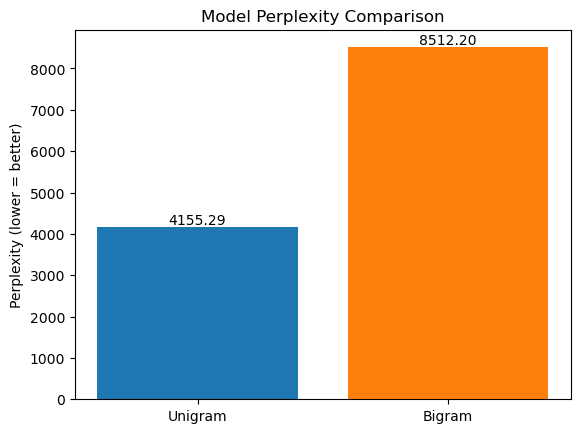

In [38]:
def compute_perplexity(model, corpus, model_label):
    """Compute and print held-out perplexity."""
    ppl = model.perplexity(corpus)
    print(f"Perplexity ({model_label}): {ppl:.2f}")
    return ppl


print("\n=== HELD-OUT EVALUATION ===")
print("Perplexity summarizes predictive quality on the 20% test split (lower is better).")

uni_ppl = compute_perplexity(uni_lm, test_corpus, "unigram")
bi_ppl = compute_perplexity(bi_lm, test_corpus, "bigram")

better = "bigram" if bi_ppl < uni_ppl else "unigram"
print(f"\n→ The {better} model generalizes better on the held-out data.\n")

# Visualization
plt.bar(["Unigram", "Bigram"], [uni_ppl, bi_ppl], color=["#1f77b4", "#ff7f0e"])
plt.ylabel("Perplexity (lower = better)")
plt.title("Model Perplexity Comparison")
for i, v in enumerate([uni_ppl, bi_ppl]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.show()

## 4. Exploring Learned N-grams

### 4.1 Why inspect counts and probabilities?
Before trusting the perplexity scores, we inspect what the models *actually* learned. Frequency tables expose memorised patterns, while direct probability checks confirm that Laplace smoothing keeps unseen events non-zero. These diagnostics catch tokenisation bugs, vocabulary issues, or unexpected contexts long before evaluation.

### 4.2 What we analyse
- **Top-N unigrams**: printing the most frequent tokens shows whether the training data contains the expected slang, hashtags, or stop words.
- **Bigram continuations**: for a chosen history (e.g., `love → ?`), we list the 10 most common successors along with their Laplace-smoothed probabilities to validate conditional counts.
- **Unseen bigram example**: demonstrating `P(word|context)` for a pair that never occurred (e.g., `love banana`) proves that smoothing prevents zero probabilities.
- **Empty-input sanity check**: calling `sentence_log_prob` on empty/whitespace strings ensures both models return `-inf` (or an early exit), confirming they handle edge cases gracefully.

In [39]:
# Top-N most frequent unigrams
n = 20
print(f"\n=== Top {n} Most Frequent Unigrams (Training Split) ===")
for word, count in uni_lm.unigram_counts.most_common(n):
    print(f"{word:<15} -> count: {count}")

# Top bigram continuations for a chosen prefix
sample_prev = "love"
top_bigrams = bi_lm.bigram_counts[sample_prev].most_common(10)

print(f"\n=== Top 10 Bigrams Starting with '{sample_prev}' (Training Split) ===")
for word, count in top_bigrams:
    prob = np.exp(bi_lm.log_prob(sample_prev, word))
    print(f"{sample_prev:<10} {word:<15} -> count: {count:<5} | P({word}|{sample_prev}) = {prob:.6f}")

# Demonstrate Laplace smoothing on unseen bigrams
unseen = ("love", "banana")
smoothed_prob = np.exp(bi_lm.log_prob(*unseen))
print("\n=== Laplace Smoothing Example ===")
print(f"Unseen bigram: {unseen[0]} {unseen[1]}")
print(f"P({unseen[1]}|{unseen[0]}) = {smoothed_prob:.8f} (non-zero due to smoothing)")


# Sanity check: empty or whitespace sentences
print("\n=== Empty Input Sanity Check ===")
print("Unigram (empty string):", uni_lm.sentence_log_prob(""))
print("Unigram (only spaces):", uni_lm.sentence_log_prob("   "))
print("Bigram (empty string):", bi_lm.sentence_log_prob(""))


=== Top 20 Most Frequent Unigrams (Training Split) ===
new             -> count: 467
day             -> count: 438
love            -> count: 423
good            -> count: 365
game            -> count: 360
year            -> count: 317
watch           -> count: 306
time            -> count: 303
happy           -> count: 294
music           -> count: 273
come            -> count: 262
win             -> count: 259
like            -> count: 255
live            -> count: 253
thank           -> count: 252
go              -> count: 246
great           -> count: 234
video           -> count: 223
world           -> count: 220
play            -> count: 216

=== Top 10 Bigrams Starting with 'love' (Training Split) ===
love       love            -> count: 10    | P(love|love) = 0.000842
love       guy             -> count: 8     | P(guy|love) = 0.000689
love       youuuu          -> count: 8     | P(youuuu|love) = 0.000689
love       thank           -> count: 7     | P(thank|love) = 0.000612
love

## 5. Optional: External Baseline with NLTK

### 5.1 Why compare with NLTK?
Validating against a well-tested library helps confirm that our implementation is correct and highlights the effect of different smoothing strategies.

> *Skip this section if you only need the custom models. The notebook remains functional without executing Section 6.*

### 5.2 Train NLTK MLE and Laplace models
We reuse the training corpus, lowercase tokens for library compatibility, and fit both Maximum Likelihood (no smoothing) and Laplace-smoothed versions using `nltk.lm`.

In [40]:
from nltk.lm import MLE, Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams

# Prepare NLTK models

n = 2  # Bigram

# Lowercase all tokens for consistency
train_corpus_lower = [[w.lower() for w in sent] for sent in train_corpus]

# --- Unigram models ---
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)

# MLE model
nltk_uni_mle = MLE(1)
nltk_uni_mle.fit(train_data_uni, vocab_uni)

# Laplace-smoothed model
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)  # re-generate generator
nltk_uni_laplace = Laplace(1)
nltk_uni_laplace.fit(train_data_uni, vocab_uni)

# --- Bigram models ---
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)

# MLE bigram
nltk_bigram_mle = MLE(n)
nltk_bigram_mle.fit(train_data_bi, vocab_bi)

# Laplace bigram
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)  # re-generate generator
nltk_bigram_laplace = Laplace(n)
nltk_bigram_laplace.fit(train_data_bi, vocab_bi)

print("NLTK MLE and Laplace models trained.")

NLTK MLE and Laplace models trained.


### 6.3 Compare n-gram statistics
We align our custom estimates with the NLTK models to check that probabilities and rankings match after smoothing.

In [41]:
# Unigram comparison table
num_items = 10
unigram_rows = []
for word, count in uni_lm.unigram_counts.most_common(num_items):
    unigram_rows.append(
        {
            "word": word,
            "custom_count": count,
            "custom_prob": math.exp(uni_lm.log_prob(word)),
            "nltk_mle_prob": nltk_uni_mle.score(word.lower(), []),
            "nltk_laplace_prob": nltk_uni_laplace.score(word.lower(), []),
        }
    )

float_fmt = lambda x: f"{x:.6f}"
unigram_df = pd.DataFrame(unigram_rows)
print(f"Top {num_items} unigram probabilities (custom vs. NLTK)")
print(unigram_df.to_string(index=False, float_format=float_fmt))

# Bigram comparison table
sample_prev = "love"
num_bigrams = 10
conditional_counts = bi_lm.bigram_counts.get(sample_prev, [])

if not conditional_counts:
    print(f"No bigrams found starting with '{sample_prev}'.")
else:
    bigram_rows = []
    for word, count in conditional_counts.most_common(num_bigrams):
        bigram_rows.append(
            {
                "bigram": f"{sample_prev} {word}",
                "custom_count": count,
                "custom_prob": math.exp(bi_lm.log_prob(sample_prev, word)),
                "nltk_mle_prob": nltk_bigram_mle.score(word.lower(), [sample_prev.lower()]),
                "nltk_laplace_prob": nltk_bigram_laplace.score(word.lower(), [sample_prev.lower()]),
            }
        )

    bigram_df = pd.DataFrame(bigram_rows)
    print("\nTop {} bigram probabilities given '{}'".format(num_bigrams, sample_prev))
    print(bigram_df.to_string(index=False, float_format=float_fmt))

print("\nInterpretation: Matching probabilities between our custom models and NLTK confirms that counting and smoothing behave identically.")

Top 10 unigram probabilities (custom vs. NLTK)
 word  custom_count  custom_prob  nltk_mle_prob  nltk_laplace_prob
  new           467     0.006028       0.007185           0.006028
  day           438     0.005654       0.006739           0.005654
 love           423     0.005461       0.006508           0.005461
 good           365     0.004714       0.005615           0.004714
 game           360     0.004650       0.005539           0.004650
 year           317     0.004096       0.004877           0.004096
watch           306     0.003954       0.004708           0.003954
 time           303     0.003916       0.004662           0.003916
happy           294     0.003800       0.004523           0.003800
music           273     0.003529       0.004200           0.003529

Top 10 bigram probabilities given 'love'
     bigram  custom_count  custom_prob  nltk_mle_prob  nltk_laplace_prob
  love love            10     0.000842       0.023641           0.000842
   love guy             8   

### 6.4 Key observations from the comparison
- Custom and NLTK MLE probabilities line up for frequent items, confirming our counting logic.
- Laplace smoothing consistently lowers probabilities because it reserves mass for unseen events.
- Discrepancies highlight where text casing or tokenisation differs; adjust preprocessing if a certain analysis requires strict comparability.

### 6.5 Sentence-level log-probability comparison
We compare sentence scores across custom and NLTK models to see how smoothing affects longer sequences. Large gaps between MLE and Laplace highlight how aggressively smoothing redistributes probability mass.

=== Sentence-level log-probabilities across models ===
Zero probabilities in the MLE models appear as -inf log-values and infinite perplexities.
          sentence custom_uni_log custom_uni_ppl custom_bi_log custom_bi_ppl nltk_uni_mle_log nltk_uni_lap_log nltk_bi_mle_log nltk_bi_lap_log
    happy new year         -16.18         220.08        -17.76        372.37             -inf           -38.70          -10.95          -22.94
good morning world         -17.52         344.10        -22.21       1639.47             -inf           -40.04            -inf          -29.95
   love play music         -16.74         264.78        -22.54       1832.06             -inf           -39.26            -inf          -29.60
   game love music         -16.23         223.46        -21.84       1449.11             -inf           -38.75          -18.43          -29.78
  watch great game         -16.70         261.92        -21.57       1327.85             -inf           -39.22          -15.89          -27.

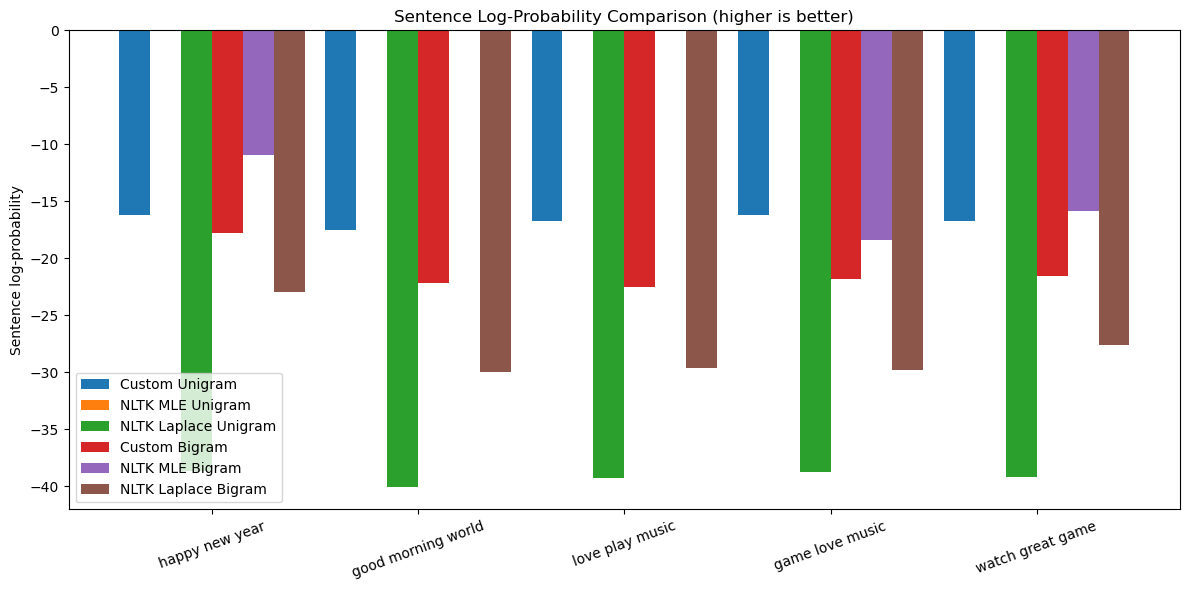


Observation: Laplace-smoothed models avoid -inf scores by assigning non-zero probability mass to unseen tokens, which keeps their perplexities finite.


In [ ]:
models = ['Custom Unigram', 'NLTK MLE Unigram', 'NLTK Laplace Unigram',
          'Custom Bigram', 'NLTK MLE Bigram', 'NLTK Laplace Bigram']

sentence_labels = sample_sentences
results = []

print("=== Sentence-level log-probabilities across models ===")
print("Zero probabilities in the MLE models appear as -inf log-values and infinite perplexities.")

for sentence in sentence_labels:
    tokens = ensure_tokens(sentence)
    token_count = len(tokens)
    tokens_lower = [token.lower() for token in tokens]

    # Custom models
    uni_log = uni_lm.sentence_log_prob(tokens)
    bi_log = bi_lm.sentence_log_prob(tokens)

    # Helper to accumulate log probabilities from NLTK models
    def nltk_sentence_log_prob(model, n, lowered_tokens):
        padded = ["<s>"] + lowered_tokens + ["</s>"]
        ngram_list = list(ngrams(padded, n))
        total = 0.0
        for gram in ngram_list:
            context = list(gram[:-1])
            prob = model.score(gram[-1], context)
            if prob <= 0:
                return float('-inf')
            total += np.log(prob)
        return total

    nltk_uni_mle_log = nltk_sentence_log_prob(nltk_uni_mle, 1, tokens_lower)
    nltk_uni_lap_log = nltk_sentence_log_prob(nltk_uni_laplace, 1, tokens_lower)
    nltk_bi_mle_log = nltk_sentence_log_prob(nltk_bigram_mle, 2, tokens_lower)
    nltk_bi_lap_log = nltk_sentence_log_prob(nltk_bigram_laplace, 2, tokens_lower)

    def log_to_perplexity(log_val):
        if not np.isfinite(log_val):
            return float('inf')
        return np.exp(-log_val / max(token_count, 1))

    results.append(
        {
            "sentence": sentence,
            "custom_uni_log": uni_log,
            "custom_uni_ppl": log_to_perplexity(uni_log),
            "custom_bi_log": bi_log,
            "custom_bi_ppl": log_to_perplexity(bi_log),
            "nltk_uni_mle_log": nltk_uni_mle_log,
            "nltk_uni_lap_log": nltk_uni_lap_log,
            "nltk_bi_mle_log": nltk_bi_mle_log,
            "nltk_bi_lap_log": nltk_bi_lap_log,
        }
    )

results_df = pd.DataFrame(results)
formatters = {col: (lambda x: f"{x:.2f}" if np.isfinite(x) else "-inf" if x == float('-inf') else "inf")
              for col in results_df.columns if col != 'sentence'}
print(results_df.to_string(index=False, formatters=formatters))

avg_perps = results_df[["custom_uni_ppl", "custom_bi_ppl"]].replace(np.inf, np.nan).mean()
if avg_perps.isnull().all():
    print("\nMean perplexities could not be computed due to infinite values (typically from zero-probability sentences).")
else:
    print("\nAverage perplexities across sample sentences:")
    for model_name, value in avg_perps.items():
        print(f"  {model_name}: {value:.2f}")

# Prepare data for visual comparison (replace -inf with NaN to avoid plotting issues)
plot_matrix = results_df[[
    "custom_uni_log", "nltk_uni_mle_log", "nltk_uni_lap_log",
    "custom_bi_log", "nltk_bi_mle_log", "nltk_bi_lap_log"
]].replace(-np.inf, np.nan).values

x = np.arange(len(sentence_labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(len(models)):
    ax.bar(x + i * width, plot_matrix[:, i], width, label=models[i])

ax.set_xticks(x + 2.5 * width)
ax.set_xticklabels(sentence_labels, rotation=20)
ax.set_ylabel('Sentence log-probability')
ax.set_title('Sentence Log-Probability Comparison (higher is better)')
ax.legend()
plt.tight_layout()
plt.show()

## Why Laplace Smoothing Matters

In a **Maximum Likelihood (MLE)** language model:

P(wᵢ | wᵢ₋₁) = count(wᵢ₋₁, wᵢ) / count(wᵢ₋₁)

If a bigram never appeared in the training data → count = 0 → P = 0 → log P = −∞  
That means the **sentence probability becomes 0** and the **perplexity becomes infinite**.

---

### Laplace Smoothing (Add-1)

Laplace smoothing fixes this problem by adding 1 to every possible count:

Pₗₐₚₗₐcₑ(wᵢ | wᵢ₋₁) = (count(wᵢ₋₁, wᵢ) + 1) / (count(wᵢ₋₁) + |V|)

This ensures:

- Every possible word gets a **small positive probability**, even if unseen.  
- log-probabilities remain **finite** (no −∞).  
- Perplexity stays **finite and comparable** across models.

---

### Quick Example

```python
print("MLE:", nltk_bigram_mle.score("banana", ["love"]))  # → 0.0
print("Laplace:", nltk_bigram_laplace.score("banana", ["love"]))  # → small > 0
